# Лабораторная работа №5

## Постановка задачи

1. Реализовать 3 генератора данных на плоскости или в пространстве

2. Реализовать метод метода Парзена-Розенблатта и восстановить плотность в виде картинки

3. Для одного из ранее определенённых наборов данных применить оптимизацию ширины окна методом Leave One Out

4. Для данных с 2-мя и более горбами применить EM-алгоритм

## Источники

* [Метод Парзена-Розенблата](https://yandex.ru/q/machine-learning/12341383425/)



# Подключение зависимостей

In [467]:
import random
import math
import numpy as np
from matplotlib import pyplot as plt
from typing import Mapping
from sklearn.mixture import GaussianMixture

# Вспомогательные методы

In [376]:
def draw_distribution(values: list, title: str):
    """Визуализация распрделения

    Args:
        values (list): список сгенерированных значений
    """
    x = np.linspace(0, 100, len(values))
    y = np.array(values)
    plt.scatter(x, y)
    plt.title(title)

# 1. Генераторы данных

## Равномерное распределение

$F_X(x) \equiv \mathbb{P}(X \leqslant x) = \left\{
\begin{matrix}
0, & x < a \\
\dfrac{x-a}{b-a}, & a \leqslant x < b \\
1, & x \geqslant b
\end{matrix}
\right..$

In [34]:
class UniformDistribution():
  
  @staticmethod
  def generate_value(alpha: float = 0., beta: float = 1.) -> float:
    return random.uniform(0, 1) * (beta - alpha) + alpha

  @staticmethod
  def generate_list(alpha: float = 0., beta: float = 1., count: int = 100) -> list:
    return [UniformDistribution.generate_value(alpha, beta) for i in range(count)]

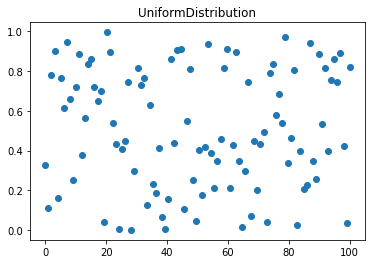

In [377]:
draw_distribution(UniformDistribution.generate_list(), "UniformDistribution")

## Экспоненциальное распределение

$F_X(x) = \left\{\begin{matrix}
1-e^{-\lambda x}&,\; x \ge 0, \\
0 &,\; x < 0.
\end{matrix}\right.$

In [47]:
class ExponentialDistribution():
  
  @staticmethod
  def generate_value(lmd: float = 0.1) -> float:
    return math.log(1 / (1 - random.uniform(0, 1))) / lmd

  @staticmethod
  def generate_list(lmd: float = 0.1, count: int = 100) -> list:
    return [ExponentialDistribution.generate_value(lmd) for i in range(count)]

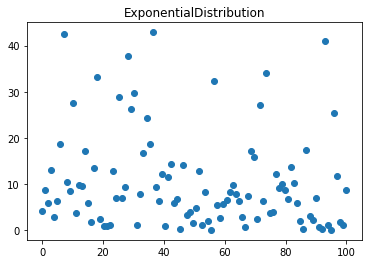

In [60]:
draw_distribution(ExponentialDistribution.generate_list(), "ExponentialDistribution")

## Распределение Вейбулла

$F(x;k,\lambda) = 1- e^{-(x/\lambda)^k}$

In [65]:
class WeibullDistribution():
  
  @staticmethod
  def generate_value(lmd: float = 1.0, k: float = 1.5) -> float:
    return (math.log(1 / (1 - random.uniform(0, 1))) / lmd ** k) ** (1 / k)

  @staticmethod
  def generate_list(lmd: float = 1., k: float = 1.5, count: int = 100) -> list:
    return [WeibullDistribution.generate_value(lmd, k) for i in range(count)]

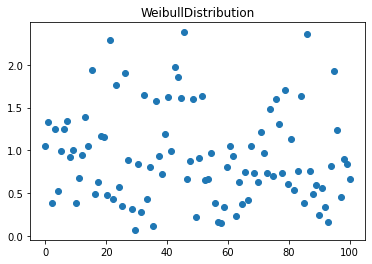

In [69]:
draw_distribution(WeibullDistribution.generate_list(), "WeibullDistribution")

# 2. Реализация метода Парзена-Розенблатта

In [74]:
class ParzenRosenblatt():

  def kernel_Cauchy(x: float) -> float:
      
    """Вычисляет значение функции ядра Коши с заданными параметрами

    Args:
        x (float): параметр функции ядра

    Returns:
        float: значение функции ядра
    """

    return 1 / (math.pi * (1 + x ** 2))

  def calculate(x: float, h: float, data: list) -> float:
      
    """Вычисляет определённое по группе точек значение

    Args:
        x (float): параметр функции ядра
        h (float): ширина окна
        data (list): список точек

    Returns:
        float: найденное значение
    """        

    return sum([ParzenRosenblatt.kernel_Cauchy((x - i) / h) for i in data]) / (len(data) * h)

In [252]:
def draw_parzen_rosenblatt_result(data: list, title: str, h: float = 0.5):

    x = np.linspace(min(data), max(data), len(data))
    calculated_values = ParzenRosenblatt.calculate(x, h, data)

    fig = plt.figure(figsize=(15, 5))

    ax1 = plt.subplot(1,2,2)
    ax2 = plt.subplot(1,2,1)
    
    ax1.scatter(np.linspace(0, len(data), len(data)), data)
    ax1.set_title("Данные")

    ax2.plot(x, calculated_values)
    ax2.set_title(title)
    ax2.set_xlim((min(data), max(data)))

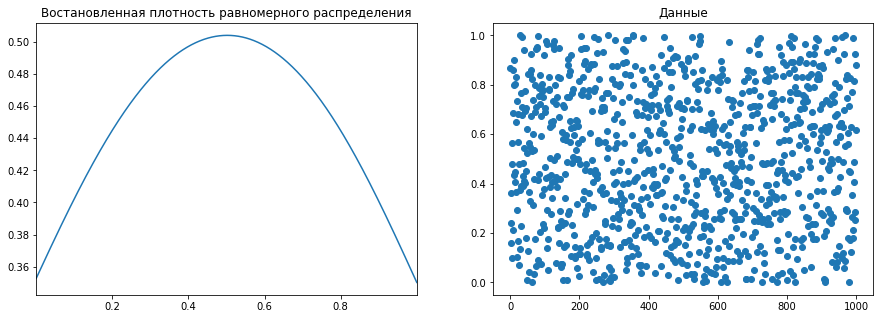

In [373]:
data = UniformDistribution.generate_list(0., 1., 1000)
draw_parzen_rosenblatt_result(data, "Востановленная плотность равномерного распределения")

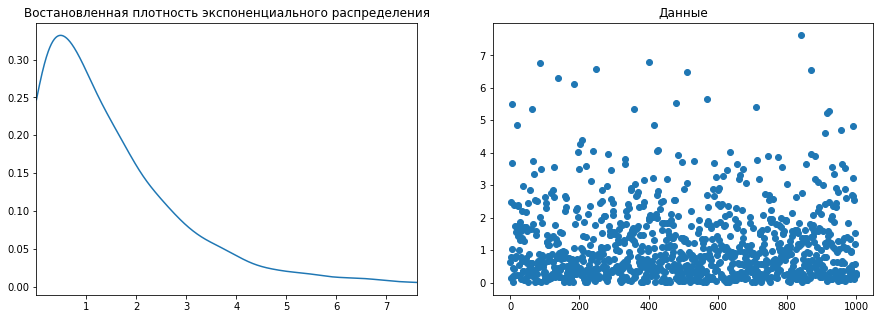

In [369]:
data = ExponentialDistribution.generate_list(0.9, 1000)
draw_parzen_rosenblatt_result(data, "Востановленная плотность экспоненциального распределения")

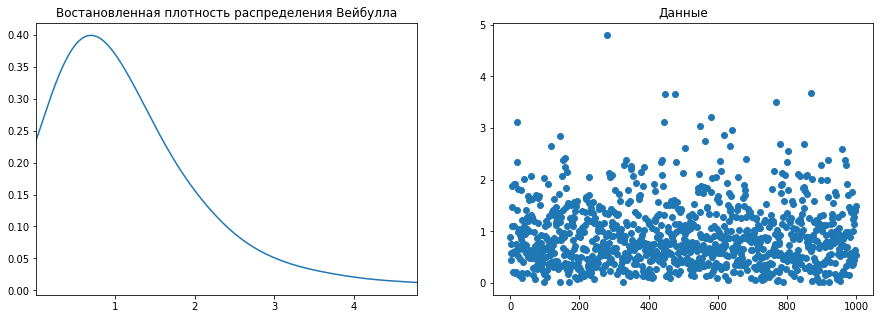

In [368]:
data = WeibullDistribution.generate_list(1, 1.5, 1000)
draw_parzen_rosenblatt_result(data, "Востановленная плотность распределения Вейбулла")

# 3. Leave one out

In [269]:
def leave_one_out(data: list, h: float) -> float:
    
    """
    Args:
        data (list): список точек
        h (float): ширина окна

    Returns:
        float: значение оптимизированной ширины окна
    """
    
    return -sum([math.log(ParzenRosenblatt.calculate(data[i], h, data[:i] + data[i+1:])) for i in range(len(data))])


In [270]:
h = 0.2
val = leave_one_out(ExponentialDistribution.generate_list(), h)
print(f'Вычислинное значение для ширины окна {h} = {val}')

Вычислинное значение для ширины окна 0.2 = 352.6046726980643


# 4. EM-алгоритм 

## Определение распределения с двумя пиками

In [481]:
def double_exponential(lmd1: float = 1., lmd2: float = 1., offset: float = 5., count: int = 500):
    
    data=[]
    for i in range(count):
        data.append(offset - ExponentialDistribution.generate_value(lmd2))
        data.append(ExponentialDistribution.generate_value(lmd1))
    return np.array(data)


## Генерация данных

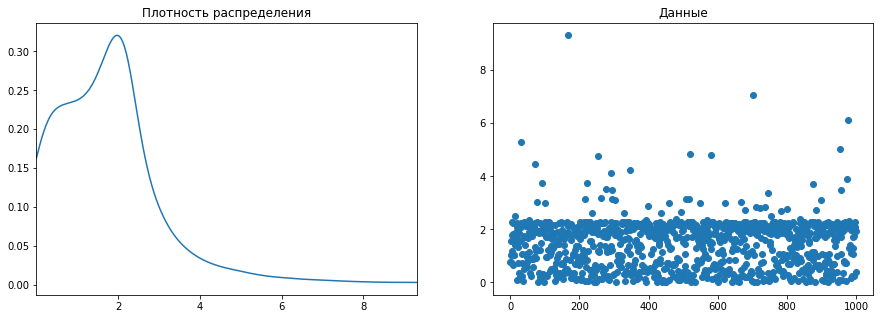

In [495]:
# lmd1 = random.uniform(0,3)
# lmd2 = random.uniform(0,3)
# offset = random.uniform(0,10)

lmd1 = 1.
lmd2 = 2.3
offset = 2.3

data = double_exponential(lmd1, lmd2, offset, 500)
draw_parzen_rosenblatt_result(data, "Плотность распределения")

In [496]:
def draw_EM_result(data):
    
    count = len(data)
    data = data.reshape(-1, 1)
    gm = GaussianMixture(n_components=2, covariance_type='full', init_params='random', random_state=0).fit(data)

    x = np.linspace(0, 1, count * 2)
    y_red = gm.predict_proba(np.array(x).reshape(-1, 1))[:,0]
    y_blue = gm.predict_proba(np.array(x).reshape(-1, 1))[:,1]
    
    plt.plot(x, y_red)
    plt.plot(x, y_blue) 
    plt.show()

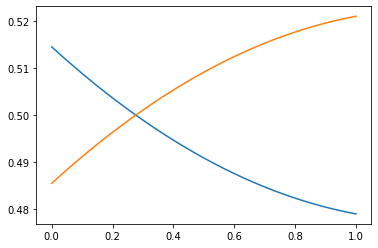

In [497]:
draw_EM_result(data)